# "전이학습"으로 소량 데이터 분류를 구현하는 방법

- 학습된 VGG 모델을 사용하여 전이학습으로 개미와 벌의 이미지를 분류하는 모델을 학습합니다


# 학습 목표

1. 이미지 데이터로 Dataset을 만들 수 있다
2. Dataset으로 DataLoader를 만들 수 있다
3. 학습된 모델의 출력층을 원하는 형태로 변경할 수 있다
4. 출력층의 결합 파라미터만 학습시켜 전이학습을 구현할 수 있다



In [1]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSet 작성

In [3]:
# 입력 이미지의 전처리 클래스
# 훈련시와 추론시 처리가 다름
class ImageTransform():
    """
    이미지 전처리 클래스. 훈련시, 검증시의 동작이 다르다.
    이미지 크기를 리사이즈하고, 색상을 표준화한다.
    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 증대한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 이미지의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # 데이터 증대
                transforms.RandomHorizontalFlip(),  # 데이터 증대
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # 리사이즈
                transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize로 자른다
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img)


In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


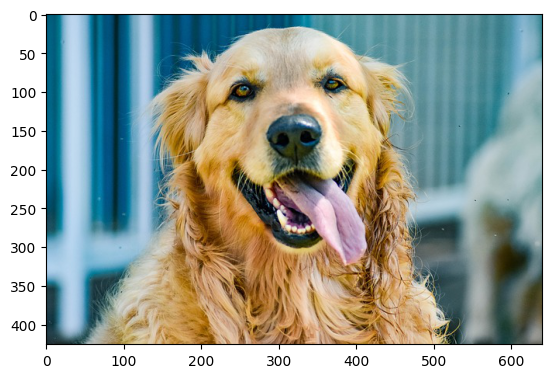

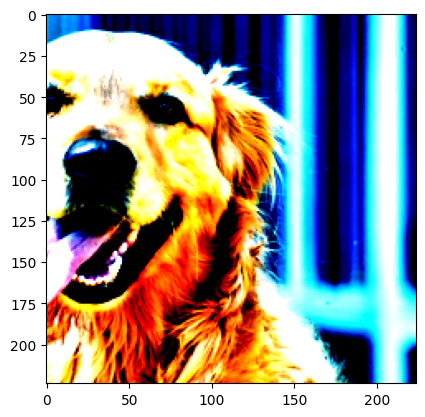

In [ ]:
# 훈련시 이미지 전처리 동작 확인
# 실행할 때마다 처리 결과 이미지가 바뀜

# 1. 이미지 읽기
image_file_path = '/content/drive/MyDrive/소프트웨어응용/3차시실습/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]

# 2. 원본 이미지 표시
plt.imshow(img)
plt.show()

# 3. 이미지 전처리, 처리된 이미지를 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


# 개미와 벌 데이터 다운로드

In [4]:
!wget --no-check-certificate https://download.pytorch.org/tutorial/hymenoptera_data.zip

import zipfile

zip_file = 'hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('./data')
zip_ref.close()

!rm hymenoptera_data.zip

--2023-04-03 07:21:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.39.6, 18.65.39.99, 18.65.39.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.39.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  26.9MB/s    in 1.7s    

2023-04-03 07:21:36 (26.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [5]:
# 개미와 벌의 이미지 파일의 경로 리스트를 작성
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정

    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # 여기에 저장한다

    # glob을 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/342438950_a3da61deab.jpg',
 './data/hymenoptera_data/train/ants/474806473_ca6caab245.jpg',
 './data/hymenoptera_data/train/ants/2278278459_6b99605e50.jpg',
 './data/hymenoptera_data/train/ants/178538489_bec7649292.jpg',
 './data/hymenoptera_data/train/ants/196757565_326437f5fe.jpg',
 './data/hymenoptera_data/train/ants/termite-vs-ant.jpg',
 './data/hymenoptera_data/train/ants/226951206_d6bf946504.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/207947948_3ab29d7207.jpg',
 './data/hymenoptera_data/train/ants/957233405_25c1d1187b.jpg',
 './data/hymenoptera_data/train/ants/382971067_0bfd33afe0.jpg',
 './data/hymenoptera_data/train/ants/154124431_65460430f2.jpg',
 './data/hymenoptera_data/train/ants/245647475_9523dfd13e.jpg',
 './data/hymenoptera_data/train/ants/841049277_b28e58ad05.jpg',
 './data/hymenoptera_data/train/ants/255434217_1b2b3fe0a4.jpg',
 './data/hymenoptera_data/train/ants/5128632

In [6]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# 개미와 벌의 이미지에 대한 Dataset을 작성한다
class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 이미지의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    file_list : 리스트
        이미지 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정한다.
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스
        self.phase = phase  # train or val 지정

    def __len__(self):
        '''이미지 개수를 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 이미지의 Tensor 형식의 데이터와 라벨을 취득
        '''

        # index번째의 이미지를 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][너비][색RGB]

        # 이미지의 전처리를 실시
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 이미지 라벨을 파일 이름에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자로 변경
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 실행
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작 확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


# DataLoader 작성

In [7]:
# 배치 크기 지정
batch_size = 32

# DataLoader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator)  # 첫번째 요소를 추출
print(inputs.size())
print(labels)


torch.Size([32, 3, 224, 224])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1])


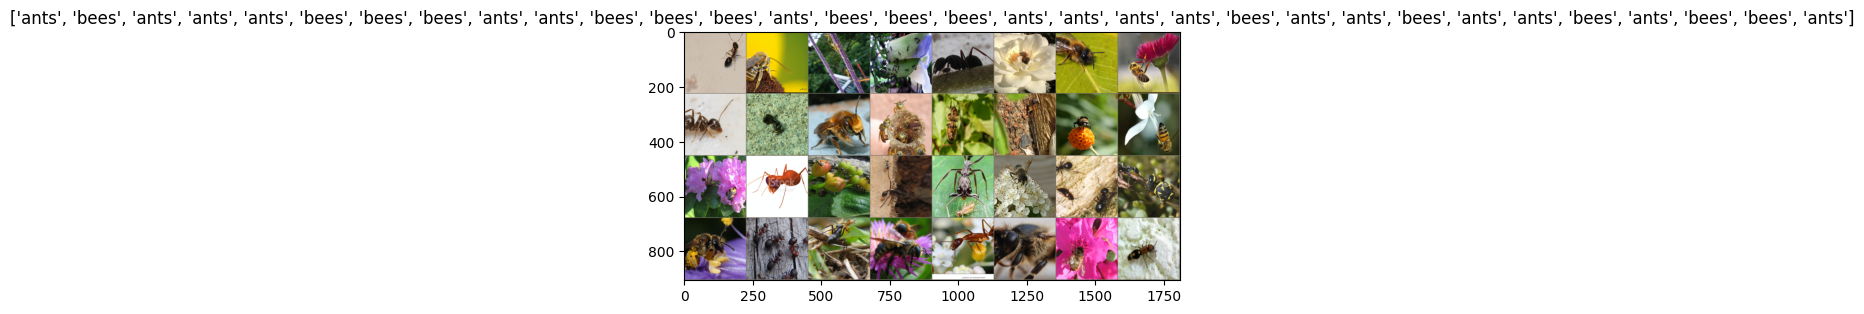

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ('ants', 'bees')
imshow(out, title=[class_names[x] for x in classes])

# 네트워크 모델 작성

In [ ]:
# 학습된 VGG-16 모델을 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌의 2개로 바꾼다
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')
print(net)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kerne

# 손실 함수 정의

In [ ]:
# 손실 함수 설정
criterion = nn.CrossEntropyLoss()


# 최적화 기법 설정

In [ ]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장한다
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 이외에는 경사를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용을 확인
print("-----------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0102,  0.0012, -0.0116,  ...,  0.0114,  0.0150,  0.0002],
        [-0.0021,  0.0004,  0.0095,  ..., -0.0047,  0.0062, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([ 0.0044, -0.0081], requires_grad=True)]


In [ ]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


# 학습 및 검증 실시

In [ ]:
# 모델을 학습시키는 함수를 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  # epoch 정답의 수

            # 미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer를 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실을 계산
                    _, preds = torch.max(outputs, 1)  # 라벨을 예측
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # loss 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch 당 loss와 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [ ]:
# 학습 및 검증 실시
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/3
-------------


100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


val Loss: 0.7925 Acc: 0.3660
Epoch 2/3
-------------


100%|██████████| 8/8 [02:28<00:00, 18.51s/it]


train Loss: 0.5279 Acc: 0.7119


100%|██████████| 5/5 [01:29<00:00, 17.89s/it]


val Loss: 0.1937 Acc: 0.9412
Epoch 3/3
-------------


100%|██████████| 8/8 [02:20<00:00, 17.60s/it]


train Loss: 0.1387 Acc: 0.9547


100%|██████████| 5/5 [01:32<00:00, 18.55s/it]

val Loss: 0.1295 Acc: 0.9542
